In [2]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import os
import cv2 
import matplotlib.pyplot as plt

In [4]:
labels = pd.read_csv("data/data.csv")

In [5]:
labels.head()

,Unnamed: 0,path,label
0,0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [6]:
labels.drop("Unnamed: 0",axis=1,inplace=True)

In [7]:
labels.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [8]:
labels.label.value_counts()

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64

In [79]:
labels.drop(labels[labels["label"] == "Surprise"].index,inplace=True)

In [80]:
labels.drop(labels[labels["label"] == "Angry"].index,inplace=True)

In [81]:
labels.drop(labels[labels["label"] == "Ahegao"].index,inplace=True)

In [82]:
labels.label.value_counts()

label
Neutral    4027
Sad        3934
Happy      3740
Name: count, dtype: int64

In [83]:
labels.head()

,path,label
1234,Sad/3fddc7ae2014f97dc0c09c20d31a08565dc600bffd...,Sad
1235,Sad/0d7f377f8a1fe48c515d1e8e5f69d54e6547340eca...,Sad
1236,Sad/6c42c733024b9d0d7f7f78de2aa0ff2c399630641a...,Sad
1237,Sad/4b47e842f6b7dac23f7e9079f949d2b69077777c57...,Sad
1238,Sad/0c0e0aa3c3423be21450a7b5cf598c3463899db327...,Sad


In [3]:
data_dir = 'data/dataset'

In [4]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, shuffle=True)

Found 11703 files belonging to 3 classes.


In [5]:
len(data)

366

In [5]:
class_names = data.class_names

In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

In [9]:
batch[1]
# 0 = happy 
# 1 = neutral
# 2 = sad

array([2, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2, 0, 0, 0, 2,
       2, 1, 2, 0, 2, 0, 1, 2, 1, 0], dtype=int32)

In [8]:
train_size = int(len(data)*0.70399)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

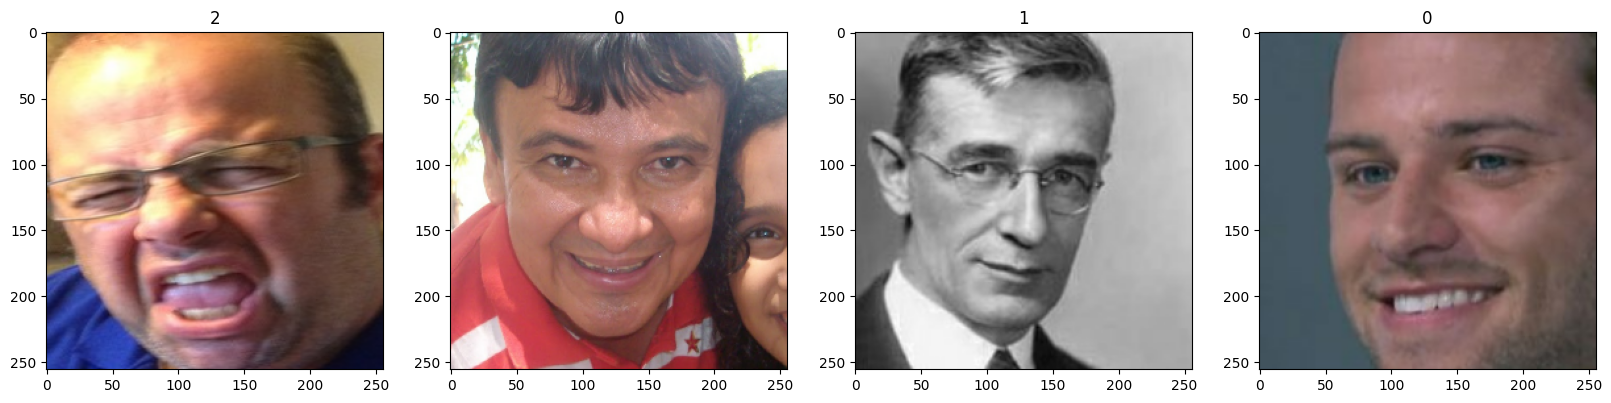

In [11]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [12]:
img = cv2.imread('data/dataset/Happy/000a72729218f928b4a9017cd09f71e30126ce497fe54446b94a90ea.JPG')

In [13]:
img.shape

(197, 197, 3)

In [9]:
data = data.map(lambda x, y: (x/255, y))

In [10]:
scaled_iterator = data.as_numpy_iterator()

In [11]:
batch = scaled_iterator.next()

In [17]:
batch[0].min()

np.float32(0.0)

In [18]:
batch[0].max()

np.float32(1.0)

In [19]:
print(train_size,test_size,val_size)

257 36 73


In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Model Training 
----
----


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [16]:
import timm
from tensorflow.keras import layers, models

In [ ]:
base_model = timm.create_model("resnet34", pretrained=False)  

input_layer = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (256, 256)))(input_layer)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(3, activation="softmax")

model = models.Model(inputs=input_layer, outputs=output_layer)


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

In [ ]:
base_model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 3))

# base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
output_layer = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()


In [ ]:
model.fit(train, validation_data = val, epochs=10)

In [25]:
model.save("classifier1.keras")

In [26]:
model_history = pd.DataFrame(model.history.history)

In [27]:
base_model.trainable = True
for layer in base_model.layers[:-10]:  
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

In [28]:
history_fine = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1031s 4s/step - accuracy: 0.4244 - loss: 2.3151 - val_accuracy: 0.3917 - val_loss: 1.2659
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 943s 4s/step - accuracy: 0.5086 - loss: 0.9568 - val_accuracy: 0.4679 - val_loss: 1.0307
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - accuracy: 0.5519 - loss: 0.8873 - val_accuracy: 0.5488 - val_loss: 0.9025
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 992s 4s/step - accuracy: 0.5714 - loss: 0.8432 - val_accuracy: 0.5180 - val_loss: 0.9576
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 982s 4s/step - accuracy: 0.5905 - loss: 0.8121 - val_accuracy: 0.4589 - val_loss: 1.1125
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 951s 4s/step - accuracy: 0.6077 - loss: 0.7957 - val_accuracy: 0.5664 - val_loss: 0.8678
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 894s 3s/step - accuracy: 0.6075 - loss: 0.7778 - val_accuracy: 0.5351 - val_loss: 0.9541
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 892s 3s/step - accuracy: 0.6222 - loss: 0.7520 - val_acc

In [29]:
model.save("classifier2.keras")

In [30]:
from tensorflow.keras.preprocessing import image

In [31]:
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(256, 256))

    predictions = model.predict(np.expand_dims(img, axis=0))
    print(predictions)
    predicted_class = np.argmax(predictions)

    return class_names[predicted_class]


In [146]:
image_path = "data/dataset/Happy/00c11a2cf326700f94125d5a2661a18e9ef06add3d07d272e996a4a7.jpg"  
prediction = predict_image(image_path, model)
print(f"Predicted class: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
[[0.26920396 0.40116227 0.32963377]]
Predicted class: Neutral


In [32]:
predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis=1)

for i, pred in enumerate(predicted_classes):
    print(f"Image {i+1}: Predicted Class = {class_names[pred]}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step
Image 1: Predicted Class = Sad
Image 2: Predicted Class = Happy
Image 3: Predicted Class = Sad
Image 4: Predicted Class = Happy
Image 5: Predicted Class = Happy
Image 6: Predicted Class = Happy
Image 7: Predicted Class = Happy
Image 8: Predicted Class = Neutral
Image 9: Predicted Class = Sad
Image 10: Predicted Class = Sad
Image 11: Predicted Class = Happy
Image 12: Predicted Class = Sad
Image 13: Predicted Class = Sad
Image 14: Predicted Class = Sad
Image 15: Predicted Class = Sad
Image 16: Predicted Class = Sad
Image 17: Predicted Class = Sad
Image 18: Predicted Class = Happy
Image 19: Predicted Class = Happy
Image 20: Predicted Class = Sad
Image 21: Predicted Class = Neutral
Image 22: Predicted Class = Neutral
Image 23: Predicted Class = Neutral
Image 24: Predicted Class = Neutral
Image 25: Predicted Class = Happy
Image 26: Predicted Class = Happy
Image 27: Predicted Class = Happy
Image 28: Predicted Class = Happy
Image 29: Predicted Class = S

In [33]:
test_loss , test_acc = model.evaluate(test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.5709 - loss: 0.8953


In [34]:
test_acc

0.5756780505180359